In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys
import random
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Math
from torch.utils.data import DataLoader, Dataset
import time
import json
from scipy.integrate import trapz

from utils import *
from model_utils import *

sys_epsilon = sys.float_info.epsilon

--------------------

# Data Preprocessing

In this section, we preprocess the CFD data collected from DSM-based LES of flow past a sphere at $\mathcal{R}e=10^3$, $5\times 10^3$, and $10^4$. The data for each Reynolds number is collected from $t=300$ to $320$. From $t=300$ to $310$, data is collected at every ten variable time-steps. However, from $t=310$ to $320$, data is collected with $\Delta t =1$.

In [2]:
paths = ["/home/hmarefat/scratch/torchFOAM/Case_dS/postProcessing/fieldData.dat",
         "/home/hmarefat/scratch/torchFOAM/Case_dS_R53/postProcessing/fieldData.dat",
         "/home/hmarefat/scratch/torchFOAM/Case_dS_R4/postProcessing/fieldData.dat"]
nCols = 26
names = ['_R3', '_R53', '_R4']

In [ ]:
random.seed(35)

count = 1000000
Indx_R3 = returnRandmIndx(4956526, count)
Indx_R53 = returnRandmIndx(5900626, count)
Indx_R4 = returnRandmIndx(4012425, count)

In [ ]:
Indx_R3[0:10]

In [ ]:
random.shuffle(Indx_R3)

In [ ]:
Indx_R3[0:10]

In [ ]:
index_data = []

for indx in [Indx_R3, Indx_R53, Indx_R4]:
    seen, unseen = splitterIndx(indx)
    index_data.append((seen, unseen))

index_array = np.array(index_data, dtype=object)

In [ ]:
index_array[2,0].shape, index_array[2,1].shape

In [ ]:
data = []

for i, path in enumerate(paths):
    name = path.split('/')[-1][:-4]+names[i]
    print(f'Starting to preprocess dataset {name}')
    data.clear()
    
    with open(path, "r") as f:
        next(f)
        for line in f:
            l = line.split()
            try:
                data.append([float(x) for x in l]) #(l)
            except ValueError as e:
                print(f"Error converting line to float: {line.strip()} - {e}")
                continue
                
    #data.pop(0)
    print('Reading raw file is done!')
    ds = np.array(data) 
    
    ds_seen = ds[index_array[i,0]]
    ds_unseen = ds[index_array[i,1]]
    
    scaler(name+'_seen', ds_seen)
    scaler(name+'_unseen', ds_unseen)
    
    print('\n')

--------------------

# Data Preparation

In [3]:
headers = ["t",                                             # time
           "X", "Y", "Z",                                   # spacial coordinates
           "Ux", "Uy", "Uz",                                # velocity components
           "G1", "G2", "G3", "G4", "G5", "G6",              # velocity gradient tensor components
           "S1", "S2", "S3", "S4", "S5", "S6",              # strain rate tensor compnents
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6",  # resolved Reynolds stress tensor components
           "Cs"]                                            # Smagorinsky coefficient

### Dataset Loading

#### $\mathcal Re = 10^3$

In [146]:
# Re = 10^3 seen
with open('../processedDatasets/fieldData_R3_seen_means.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R103_seen_means = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

with open('../processedDatasets/fieldData_R3_seen_scales.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R103_seen_scales = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

dSn_R103_seen = pd.read_csv('../processedDatasets/fieldData_R3_seen_norm.txt', sep=' ', names=headers)
dS_R103_seen = pd.read_csv('../processedDatasets/fieldData_R3_seen.txt', sep=' ', names=headers)

# Re = 10^3 unseen
with open('../processedDatasets/fieldData_R3_unseen_means.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R103_unseen_means = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

with open('../processedDatasets/fieldData_R3_unseen_scales.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R103_unseen_scales = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

dSn_R103_unseen = pd.read_csv('../processedDatasets/fieldData_R3_unseen_norm.txt', sep=' ', names=headers)
dS_R103_unseen = pd.read_csv('../processedDatasets/fieldData_R3_unseen.txt', sep=' ', names=headers)

#### $\mathcal Re = 5\times 10^3$

In [147]:
# Re = 5 x 10^3 seen
with open('../processedDatasets/fieldData_R53_seen_means.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R503_seen_means = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

with open('../processedDatasets/fieldData_R53_seen_scales.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R503_seen_scales = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

dSn_R503_seen = pd.read_csv('../processedDatasets/fieldData_R53_seen_norm.txt', sep=' ', names=headers)
dS_R503_seen = pd.read_csv('../processedDatasets/fieldData_R53_seen.txt', sep=' ', names=headers)

# Re = 5 x 10^3 unseen
with open('../processedDatasets/fieldData_R53_unseen_means.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R503_unseen_means = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

with open('../processedDatasets/fieldData_R53_unseen_scales.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R503_unseen_scales = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

dSn_R503_unseen = pd.read_csv('../processedDatasets/fieldData_R53_unseen_norm.txt', sep=' ', names=headers)
dS_R503_unseen = pd.read_csv('../processedDatasets/fieldData_R53_unseen.txt', sep=' ', names=headers)

#### $\mathcal Re = 10^4$

In [148]:
# Re = 10^4 seen
with open('../processedDatasets/fieldData_R4_seen_means.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R104_seen_means = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

with open('../processedDatasets/fieldData_R4_seen_scales.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R104_seen_scales = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

dSn_R104_seen = pd.read_csv('../processedDatasets/fieldData_R4_seen_norm.txt', sep=' ', names=headers)
dS_R104_seen = pd.read_csv('../processedDatasets/fieldData_R4_seen.txt', sep=' ', names=headers)

# Re = 10^4 unseen
with open('../processedDatasets/fieldData_R4_unseen_means.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R104_unseen_means = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

with open('../processedDatasets/fieldData_R4_unseen_scales.txt', 'r') as file:
    data = [float(line.strip()) for line in file]
dSn_R104_unseen_scales = pd.DataFrame(np.reshape(data, (-1, len(headers))), columns=headers)

dSn_R104_unseen = pd.read_csv('../processedDatasets/fieldData_R4_unseen_norm.txt', sep=' ', names=headers)
dS_R104_unseen = pd.read_csv('../processedDatasets/fieldData_R4_unseen.txt', sep=' ', names=headers)

--------------------

# Model Configuration Setup

In this section, we consider the different model configurations as presented in the following table.

$$
\begin{array}{|l|c|c|c|c|}
    \hline
    \textbf{Model} & \textbf{Inputs} & \textbf{No. of Inputs} & \textbf{Outputs} & \textbf{No. of Outputs} \\
    \hline
    \mathbf{M1} & u_i \, \text{and} \, \mathcal{S}_{ij} & 9 & c_s & 1\\
    \mathbf{M2} & \mathcal{G}_{ij} \, \text{and} \, \mathcal{S}_{ij} & 12 & c_s & 1 \\
    \mathbf{M3} & u_i \, \text{and} \, \tau^{'}_{ij} & 9 & c_s & 1 \\
    \mathbf{M4} & \mathcal{G}_{ij} \, \text{and} \, \tau^{'}_{ij} & 12 & c_s & 1 \\
    \hline
\end{array}
$$

In [149]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = dSn_R103_seen.filter(M1_headers, axis=1)
M2_103 = dSn_R103_seen.filter(M2_headers, axis=1)
M3_103 = dSn_R103_seen.filter(M3_headers, axis=1)
M4_103 = dSn_R103_seen.filter(M4_headers, axis=1)

M1_503 = dSn_R503_seen.filter(M1_headers, axis=1)
M2_503 = dSn_R503_seen.filter(M2_headers, axis=1)
M3_503 = dSn_R503_seen.filter(M3_headers, axis=1)
M4_503 = dSn_R503_seen.filter(M4_headers, axis=1)

M1_104 = dSn_R104_seen.filter(M1_headers, axis=1)
M2_104 = dSn_R104_seen.filter(M2_headers, axis=1)
M3_104 = dSn_R104_seen.filter(M3_headers, axis=1)
M4_104 = dSn_R104_seen.filter(M4_headers, axis=1)

M1_103_test = dSn_R103_unseen.filter(M1_headers, axis=1)
M2_103_test = dSn_R103_unseen.filter(M2_headers, axis=1)
M3_103_test = dSn_R103_unseen.filter(M3_headers, axis=1)
M4_103_test = dSn_R103_unseen.filter(M4_headers, axis=1)

M1_503_test = dSn_R503_unseen.filter(M1_headers, axis=1)
M2_503_test = dSn_R503_unseen.filter(M2_headers, axis=1)
M3_503_test = dSn_R503_unseen.filter(M3_headers, axis=1)
M4_503_test = dSn_R503_unseen.filter(M4_headers, axis=1)

M1_104_test = dSn_R104_unseen.filter(M1_headers, axis=1)
M2_104_test = dSn_R104_unseen.filter(M2_headers, axis=1)
M3_104_test = dSn_R104_unseen.filter(M3_headers, axis=1)
M4_104_test = dSn_R104_unseen.filter(M4_headers, axis=1)

--------------------

# Model Training

In [16]:
dt = M4_104
dt_name = namestr(M4_104, globals())[0]

In [17]:
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] 
hidden_layers = len(neurons_per_layer) 

split_sz = 0.8
mask = np.random.rand(len(dt)) < split_sz
train = dt[mask].reset_index(drop=True) 
val = dt[~mask].reset_index(drop=True)

In [18]:
train

,G1,G2,G3,G4,G5,G6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-0.030288,-0.099401,-0.093050,-0.044349,0.073241,0.071077,-0.621343,0.005343,0.001508,-0.727846,0.024628,-0.723760,-1.004127
1,-0.197695,-0.242680,0.244637,0.835817,-1.329357,0.323531,-0.576310,-0.179442,0.034037,-0.476491,-0.439450,-0.646736,0.517645
2,-0.229502,-0.082355,-0.049943,0.005463,0.058222,-0.131098,-0.206289,0.149457,0.584462,-0.410026,0.766261,-0.168835,-0.289756
3,-0.618960,-0.582423,-0.004830,0.100815,-0.213630,-0.717968,-0.046226,-0.724693,0.063926,-0.055390,-0.104848,-0.493566,0.266733
4,-0.030994,0.652822,-0.045647,-0.148220,0.266144,-0.168707,-0.249698,-0.002098,-0.543235,-0.440977,-0.039008,-0.175606,-1.158358
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559861,0.497272,-0.566571,-3.453885,-0.884785,-0.153910,1.150560,2.288330,-2.898927,4.222684,4.088178,0.486467,3.742809,0.653598
559862,0.210802,0.010281,1.138833,0.914302,0.851010,-1.320538,-0.137856,0.121102,-0.623054,-0.325073,-0.726222,-0.028926,0.372382
559863,0.719513,-0.389316,-0.419565,-0.152395,-0.146498,-0.100599,-0.333556,0.240537,-0.080920,-0.096904,-0.444976,-0.156379,-0.127999
559864,0.183035,0.044767,0.739180,0.015846,-0.085614,-0.129985,-0.465270,0.158376,-0.265106,-0.476840,-0.927122,-0.356582,-0.469827


In [19]:
val

,G1,G2,G3,G4,G5,G6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-0.277702,-0.309517,-0.278697,-0.262390,2.116101,-0.177730,-0.107838,0.499091,0.493286,-0.241080,1.593029,-0.235460,-0.763831
1,-0.772137,0.513049,-0.205001,-0.710956,0.059244,0.536323,2.755893,0.483530,3.612433,0.817401,-0.960651,1.285325,-0.427366
2,-0.838453,0.744977,-0.456138,0.865464,0.259171,-0.538470,1.425953,-0.354646,2.768895,0.772557,-1.484768,1.375806,0.893781
3,0.178851,-0.154611,0.137452,-0.041943,-0.064516,0.120205,-0.625521,-0.000649,0.000772,-0.726628,-0.153693,-0.734178,0.066254
4,-0.246182,-0.174444,0.762290,-0.191101,0.920734,-0.064500,-0.121062,-0.395362,-0.391524,0.271536,1.391390,0.265579,-0.221112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140129,0.093114,-0.102393,0.097701,-0.048277,0.054357,0.104536,-0.499690,-0.134121,-0.184605,-0.518339,0.852898,-0.481298,-0.005562
140130,-0.303878,-0.491875,0.160288,-0.151132,-0.430951,-0.327318,0.683461,-0.034132,0.404585,-0.480755,-0.428242,-0.441972,-0.285392
140131,1.121228,0.054102,-0.604508,-0.139719,-0.495827,-0.325567,-0.325384,0.224252,-0.008548,-0.046580,-0.177839,-0.099425,-0.750080
140132,-0.566945,-0.458516,-0.219772,0.461741,-0.048761,0.130086,0.250076,1.034091,0.798995,0.271130,1.726371,0.135776,-0.217909


In [20]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)

train_dataset = MyDataset(train)
val_dataset = MyDataset(val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_sz_val, shuffle=True)

In [21]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([ 0.2846, -0.4830, -0.1246, -0.0058,  0.0379, -0.4982,  0.3161, -0.0812,
         1.2684, -0.0688, -0.2076,  0.4269, -0.6051], dtype=torch.float64)

In [22]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

device = torch.device("cuda")
model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [23]:
epochs = 6000
best_loss = float('inf')
PATH = f"./best_model_{dt_name}.pt"

early_stopper = EarlyStopper(patience=50, path=PATH)
history = {
    "train_loss": [],
    "val_loss": [],
    "train_coefficient": [],
    "val_coefficient": [],
    "learning_rates": [],
    "epoch_times": []
}


for epoch in range(epochs):
    start_time = time.time()
    model.train()
    Loss_train = 0 
    coeff_train = 0

    with tqdm(train_loader, unit="batch") as trainer:
        for batch in trainer:
            trainer.set_description("Train")
            train_feat = batch[:, 0:-1].to(device)
            train_labs = batch[:, -1].to(device)
            train_pred = model(train_feat).squeeze()
            train_loss = torch.nn.functional.mse_loss(train_pred, train_labs)
            train_coef = coeff_determination(train_pred, train_labs) 

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            Loss_train += train_loss.item()
            coeff_train += train_coef.item()

        Loss_train /= len(trainer)
        coeff_train /= len(trainer)

    model.eval()
    Loss_val = 0
    coeff_val = 0
    with tqdm(val_loader, unit="batch") as validator:
        for batch in validator:
            validator.set_description("Valid")
            val_feat = batch[:, 0:-1].to(device)
            val_labs = batch[:, -1].to(device)
            val_pred = model(val_feat).squeeze()
            val_loss = torch.nn.functional.mse_loss(val_pred, val_labs)
            val_coef = coeff_determination(val_pred, val_labs) 

            Loss_val += val_loss.item()
            coeff_val += val_coef.item()

        Loss_val /= len(validator)
        coeff_val /= len(validator)
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    history["learning_rates"].append(current_lr)
    
    epoch_duration = time.time() - start_time

    history["train_loss"].append(Loss_train)
    history["val_loss"].append(Loss_val)
    history["train_coefficient"].append(coeff_train)
    history["val_coefficient"].append(coeff_val)
    history["learning_rates"].append(optimizer.param_groups[0]['lr'])
    history["epoch_times"].append(epoch_duration)

    if early_stopper.early_stop(model.state_dict(), Loss_val):             
        print("Early stopping...")
        break
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {Loss_train:.4f}, Train Coeff: {coeff_train:.4f}, "
          f"Val Loss: {Loss_val:.4f}, Val Coeff: {coeff_val:.4f}, Time: {epoch_duration:.2f} sec")

    
with open(f"training_history_{dt_name}.json", "w") as f:
    json.dump(history, f)
    
print(f"Training history saved to 'training_history_{dt_name}.json'")

data_iter = iter(train_loader)
next(data_iter)[:,0:-1]

traced_script_module = torch.jit.trace(model, next(data_iter)[:,0:-1].to(device))
traced_script_module.save(f"traced_model_{dt_name}.pt")

print(f"Training history saved to 'traced_model_{dt_name}.pt'")

Valid: 100%|██████████| 137/137 [00:05<00:00, 25.53batch/s]


Epoch 1/6000, Train Loss: 0.9693, Train Coeff: -4750.0678, Val Loss: 0.9338, Val Coeff: -21.7578, Time: 25.94 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.53batch/s]


Epoch 2/6000, Train Loss: 0.9149, Train Coeff: -12.1227, Val Loss: 0.8886, Val Coeff: -9.3821, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.67batch/s]


Epoch 3/6000, Train Loss: 0.8849, Train Coeff: -7.8455, Val Loss: 0.8665, Val Coeff: -7.4726, Time: 26.04 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.54batch/s]


Epoch 4/6000, Train Loss: 0.8626, Train Coeff: -6.3857, Val Loss: 0.8500, Val Coeff: -6.2133, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.59batch/s]


Epoch 5/6000, Train Loss: 0.8559, Train Coeff: -5.9334, Val Loss: 0.8464, Val Coeff: -5.0695, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.68batch/s]


Epoch 6/6000, Train Loss: 0.8508, Train Coeff: -5.5559, Val Loss: 0.8398, Val Coeff: -4.9128, Time: 25.93 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.70batch/s]


Epoch 7/6000, Train Loss: 0.8452, Train Coeff: -5.2948, Val Loss: 0.8380, Val Coeff: -5.3762, Time: 25.93 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.36batch/s]


Epoch 8/6000, Train Loss: 0.8440, Train Coeff: -5.2926, Val Loss: 0.8373, Val Coeff: -5.1170, Time: 26.04 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.70batch/s]


Epoch 9/6000, Train Loss: 0.8430, Train Coeff: -5.1755, Val Loss: 0.8366, Val Coeff: -5.7474, Time: 25.98 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.65batch/s]


Epoch 10/6000, Train Loss: 0.8422, Train Coeff: -5.3076, Val Loss: 0.8360, Val Coeff: -5.0762, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.98batch/s]


Epoch 11/6000, Train Loss: 0.8415, Train Coeff: -5.0846, Val Loss: 0.8359, Val Coeff: -5.1111, Time: 25.93 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.90batch/s]


Epoch 12/6000, Train Loss: 0.8416, Train Coeff: -5.0636, Val Loss: 0.8357, Val Coeff: -5.1794, Time: 25.93 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.01batch/s]


Epoch 13/6000, Train Loss: 0.8404, Train Coeff: -5.1612, Val Loss: 0.8353, Val Coeff: -5.0571, Time: 25.88 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.08batch/s]


Epoch 14/6000, Train Loss: 0.8414, Train Coeff: -5.1243, Val Loss: 0.8357, Val Coeff: -5.1996, Time: 25.93 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.94batch/s]


Epoch 15/6000, Train Loss: 0.8411, Train Coeff: -5.0794, Val Loss: 0.8360, Val Coeff: -5.0526, Time: 25.98 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.92batch/s]


Epoch 16/6000, Train Loss: 0.8414, Train Coeff: -5.1182, Val Loss: 0.8353, Val Coeff: -5.1596, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.08batch/s]


Epoch 17/6000, Train Loss: 0.8408, Train Coeff: -5.1118, Val Loss: 0.8355, Val Coeff: -5.1088, Time: 25.96 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.08batch/s]


Epoch 18/6000, Train Loss: 0.8411, Train Coeff: -5.0989, Val Loss: 0.8353, Val Coeff: -5.1262, Time: 25.99 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.89batch/s]


Epoch 19/6000, Train Loss: 0.8407, Train Coeff: -5.0698, Val Loss: 0.8357, Val Coeff: -5.1084, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.00batch/s]


Epoch 20/6000, Train Loss: 0.8408, Train Coeff: -5.1327, Val Loss: 0.8354, Val Coeff: -5.2403, Time: 25.92 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.01batch/s]


Epoch 21/6000, Train Loss: 0.8405, Train Coeff: -5.1057, Val Loss: 0.8355, Val Coeff: -5.1458, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.09batch/s]


Epoch 22/6000, Train Loss: 0.8406, Train Coeff: -5.0991, Val Loss: 0.8354, Val Coeff: -5.1238, Time: 25.90 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.90batch/s]


Epoch 23/6000, Train Loss: 0.8408, Train Coeff: -5.1118, Val Loss: 0.8354, Val Coeff: -5.0219, Time: 25.96 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.00batch/s]


Epoch 24/6000, Train Loss: 0.8407, Train Coeff: -5.0927, Val Loss: 0.8353, Val Coeff: -5.1098, Time: 25.99 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.02batch/s]


Epoch 25/6000, Train Loss: 0.8410, Train Coeff: -5.1057, Val Loss: 0.8353, Val Coeff: -5.0719, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.94batch/s]


Epoch 26/6000, Train Loss: 0.8407, Train Coeff: -5.1035, Val Loss: 0.8353, Val Coeff: -5.0640, Time: 25.94 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.91batch/s]


Epoch 27/6000, Train Loss: 0.8412, Train Coeff: -5.1082, Val Loss: 0.8354, Val Coeff: -5.1690, Time: 26.01 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.43batch/s]


Epoch 28/6000, Train Loss: 0.8410, Train Coeff: -5.0916, Val Loss: 0.8356, Val Coeff: -5.0982, Time: 26.25 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.08batch/s]


Epoch 29/6000, Train Loss: 0.8407, Train Coeff: -5.1257, Val Loss: 0.8354, Val Coeff: -5.1304, Time: 26.10 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 24.99batch/s]


Epoch 30/6000, Train Loss: 0.8409, Train Coeff: -5.0986, Val Loss: 0.8355, Val Coeff: -5.1394, Time: 26.06 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.68batch/s]


Epoch 31/6000, Train Loss: 0.8410, Train Coeff: -5.1190, Val Loss: 0.8361, Val Coeff: -5.2226, Time: 26.10 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.00batch/s]


Epoch 32/6000, Train Loss: 0.8407, Train Coeff: -5.1026, Val Loss: 0.8354, Val Coeff: -5.1596, Time: 25.99 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.97batch/s]


Epoch 33/6000, Train Loss: 0.8408, Train Coeff: -5.1213, Val Loss: 0.8355, Val Coeff: -5.2440, Time: 26.06 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.89batch/s]


Epoch 34/6000, Train Loss: 0.8409, Train Coeff: -5.1203, Val Loss: 0.8355, Val Coeff: -5.1131, Time: 25.94 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.99batch/s]


Epoch 35/6000, Train Loss: 0.8409, Train Coeff: -5.1143, Val Loss: 0.8357, Val Coeff: -5.0980, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.56batch/s]


Epoch 36/6000, Train Loss: 0.8417, Train Coeff: -5.1138, Val Loss: 0.8354, Val Coeff: -5.2232, Time: 26.07 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.65batch/s]


Epoch 37/6000, Train Loss: 0.8409, Train Coeff: -5.1036, Val Loss: 0.8352, Val Coeff: -4.9965, Time: 26.00 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.66batch/s]


Epoch 38/6000, Train Loss: 0.8406, Train Coeff: -5.0777, Val Loss: 0.8354, Val Coeff: -5.1228, Time: 25.96 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.49batch/s]


Epoch 39/6000, Train Loss: 0.8407, Train Coeff: -5.1167, Val Loss: 0.8354, Val Coeff: -5.2077, Time: 26.00 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.52batch/s]


Epoch 40/6000, Train Loss: 0.8406, Train Coeff: -5.0896, Val Loss: 0.8354, Val Coeff: -5.0621, Time: 26.05 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.66batch/s]


Epoch 41/6000, Train Loss: 0.8410, Train Coeff: -5.1132, Val Loss: 0.8356, Val Coeff: -5.1173, Time: 26.06 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.49batch/s]


Epoch 42/6000, Train Loss: 0.8404, Train Coeff: -5.0968, Val Loss: 0.8356, Val Coeff: -5.0734, Time: 26.04 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.60batch/s]


Epoch 43/6000, Train Loss: 0.8405, Train Coeff: -5.1010, Val Loss: 0.8360, Val Coeff: -5.1145, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.05batch/s]


Epoch 44/6000, Train Loss: 0.8407, Train Coeff: -5.1031, Val Loss: 0.8357, Val Coeff: -5.1910, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.85batch/s]


Epoch 45/6000, Train Loss: 0.8405, Train Coeff: -5.1329, Val Loss: 0.8353, Val Coeff: -5.0829, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.97batch/s]


Epoch 46/6000, Train Loss: 0.8406, Train Coeff: -5.1037, Val Loss: 0.8356, Val Coeff: -5.1809, Time: 25.84 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.02batch/s]


Epoch 47/6000, Train Loss: 0.8409, Train Coeff: -5.1315, Val Loss: 0.8353, Val Coeff: -5.1118, Time: 25.94 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.06batch/s]


Epoch 48/6000, Train Loss: 0.8406, Train Coeff: -5.0981, Val Loss: 0.8353, Val Coeff: -5.0667, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.80batch/s]


Epoch 49/6000, Train Loss: 0.8405, Train Coeff: -5.1130, Val Loss: 0.8354, Val Coeff: -5.1395, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.05batch/s]


Epoch 50/6000, Train Loss: 0.8406, Train Coeff: -5.1063, Val Loss: 0.8353, Val Coeff: -5.1548, Time: 25.96 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.90batch/s]


Epoch 51/6000, Train Loss: 0.8412, Train Coeff: -5.1167, Val Loss: 0.8354, Val Coeff: -5.1113, Time: 26.00 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.96batch/s]


Epoch 52/6000, Train Loss: 0.8407, Train Coeff: -5.1270, Val Loss: 0.8356, Val Coeff: -5.1416, Time: 25.98 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.83batch/s]


Epoch 53/6000, Train Loss: 0.8409, Train Coeff: -5.0864, Val Loss: 0.8355, Val Coeff: -5.1208, Time: 26.01 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.94batch/s]


Epoch 54/6000, Train Loss: 0.8408, Train Coeff: -5.1064, Val Loss: 0.8354, Val Coeff: -5.1303, Time: 26.05 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.92batch/s]


Epoch 55/6000, Train Loss: 0.8410, Train Coeff: -5.1058, Val Loss: 0.8354, Val Coeff: -5.1394, Time: 25.97 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.97batch/s]


Epoch 56/6000, Train Loss: 0.8407, Train Coeff: -5.1307, Val Loss: 0.8355, Val Coeff: -5.1912, Time: 25.92 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.81batch/s]


Epoch 57/6000, Train Loss: 0.8403, Train Coeff: -5.1225, Val Loss: 0.8354, Val Coeff: -5.0549, Time: 26.04 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.02batch/s]


Epoch 58/6000, Train Loss: 0.8409, Train Coeff: -5.1005, Val Loss: 0.8354, Val Coeff: -5.1426, Time: 25.94 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.93batch/s]


Epoch 59/6000, Train Loss: 0.8412, Train Coeff: -5.1200, Val Loss: 0.8357, Val Coeff: -5.1773, Time: 26.00 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.96batch/s]


Epoch 60/6000, Train Loss: 0.8411, Train Coeff: -5.1127, Val Loss: 0.8355, Val Coeff: -5.0774, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.87batch/s]


Epoch 61/6000, Train Loss: 0.8409, Train Coeff: -5.1299, Val Loss: 0.8355, Val Coeff: -5.1806, Time: 25.98 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.09batch/s]


Epoch 62/6000, Train Loss: 0.8409, Train Coeff: -5.1397, Val Loss: 0.8354, Val Coeff: -5.0796, Time: 26.02 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.01batch/s]


Epoch 63/6000, Train Loss: 0.8407, Train Coeff: -5.1100, Val Loss: 0.8359, Val Coeff: -5.3304, Time: 25.94 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.93batch/s]


Epoch 64/6000, Train Loss: 0.8404, Train Coeff: -5.1116, Val Loss: 0.8354, Val Coeff: -5.1073, Time: 25.98 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.00batch/s]


Epoch 65/6000, Train Loss: 0.8403, Train Coeff: -5.1132, Val Loss: 0.8354, Val Coeff: -5.2182, Time: 25.96 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.59batch/s]


Epoch 66/6000, Train Loss: 0.8406, Train Coeff: -5.1032, Val Loss: 0.8354, Val Coeff: -5.0032, Time: 26.03 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.61batch/s]


Epoch 67/6000, Train Loss: 0.8405, Train Coeff: -5.0991, Val Loss: 0.8355, Val Coeff: -5.1528, Time: 26.07 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.23batch/s]


Epoch 68/6000, Train Loss: 0.8409, Train Coeff: -5.1065, Val Loss: 0.8357, Val Coeff: -5.1122, Time: 26.15 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.64batch/s]


Epoch 69/6000, Train Loss: 0.8405, Train Coeff: -5.0943, Val Loss: 0.8353, Val Coeff: -5.0985, Time: 25.92 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.51batch/s]


Epoch 70/6000, Train Loss: 0.8410, Train Coeff: -5.0716, Val Loss: 0.8353, Val Coeff: -5.1363, Time: 26.00 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.50batch/s]


Epoch 71/6000, Train Loss: 0.8409, Train Coeff: -5.1086, Val Loss: 0.8353, Val Coeff: -5.0759, Time: 26.05 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.45batch/s]


Epoch 72/6000, Train Loss: 0.8404, Train Coeff: -5.0939, Val Loss: 0.8355, Val Coeff: -5.1045, Time: 26.11 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.48batch/s]


Epoch 73/6000, Train Loss: 0.8409, Train Coeff: -5.0827, Val Loss: 0.8354, Val Coeff: -5.1474, Time: 25.95 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 25.79batch/s]


Epoch 74/6000, Train Loss: 0.8409, Train Coeff: -5.1330, Val Loss: 0.8353, Val Coeff: -5.0833, Time: 26.24 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.27batch/s]


Epoch 75/6000, Train Loss: 0.8404, Train Coeff: -5.1246, Val Loss: 0.8353, Val Coeff: -5.2724, Time: 25.72 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.05batch/s]


Epoch 76/6000, Train Loss: 0.8407, Train Coeff: -5.1200, Val Loss: 0.8356, Val Coeff: -5.1738, Time: 25.76 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.33batch/s]


Epoch 77/6000, Train Loss: 0.8406, Train Coeff: -5.0890, Val Loss: 0.8355, Val Coeff: -5.2154, Time: 25.59 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.18batch/s]


Epoch 78/6000, Train Loss: 0.8409, Train Coeff: -5.0977, Val Loss: 0.8355, Val Coeff: -5.1163, Time: 25.69 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.32batch/s]


Epoch 79/6000, Train Loss: 0.8405, Train Coeff: -5.1198, Val Loss: 0.8354, Val Coeff: -5.0766, Time: 25.62 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.16batch/s]


Epoch 80/6000, Train Loss: 0.8406, Train Coeff: -5.1345, Val Loss: 0.8354, Val Coeff: -5.1420, Time: 25.81 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.39batch/s]


Epoch 81/6000, Train Loss: 0.8414, Train Coeff: -5.1082, Val Loss: 0.8354, Val Coeff: -5.0480, Time: 25.66 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.08batch/s]


Epoch 82/6000, Train Loss: 0.8405, Train Coeff: -5.1045, Val Loss: 0.8354, Val Coeff: -5.2007, Time: 25.76 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.25batch/s]


Epoch 83/6000, Train Loss: 0.8404, Train Coeff: -5.1220, Val Loss: 0.8353, Val Coeff: -5.1147, Time: 25.70 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.28batch/s]


Epoch 84/6000, Train Loss: 0.8405, Train Coeff: -5.1140, Val Loss: 0.8355, Val Coeff: -5.0883, Time: 25.77 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.30batch/s]


Epoch 85/6000, Train Loss: 0.8405, Train Coeff: -5.0921, Val Loss: 0.8358, Val Coeff: -5.1726, Time: 25.68 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.18batch/s]


Epoch 86/6000, Train Loss: 0.8409, Train Coeff: -5.0936, Val Loss: 0.8354, Val Coeff: -5.1546, Time: 25.65 sec


Valid: 100%|██████████| 137/137 [00:05<00:00, 26.56batch/s]


+++ Early Stopping is reached! +++
Early stopping...
Training history saved to 'training_history_M4_104.json'
Training history saved to 'traced_model_M4_104.pt'


----------------------

# Model Analysis

In [154]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## $\mathcal Re = 10^3$

--- Using this Model Config: M1_103
--- Running on cuda!
--- Using this Model Config: M2_103
--- Running on cuda!
--- Using this Model Config: M3_103
--- Running on cuda!
--- Using this Model Config: M4_103
--- Running on cuda!


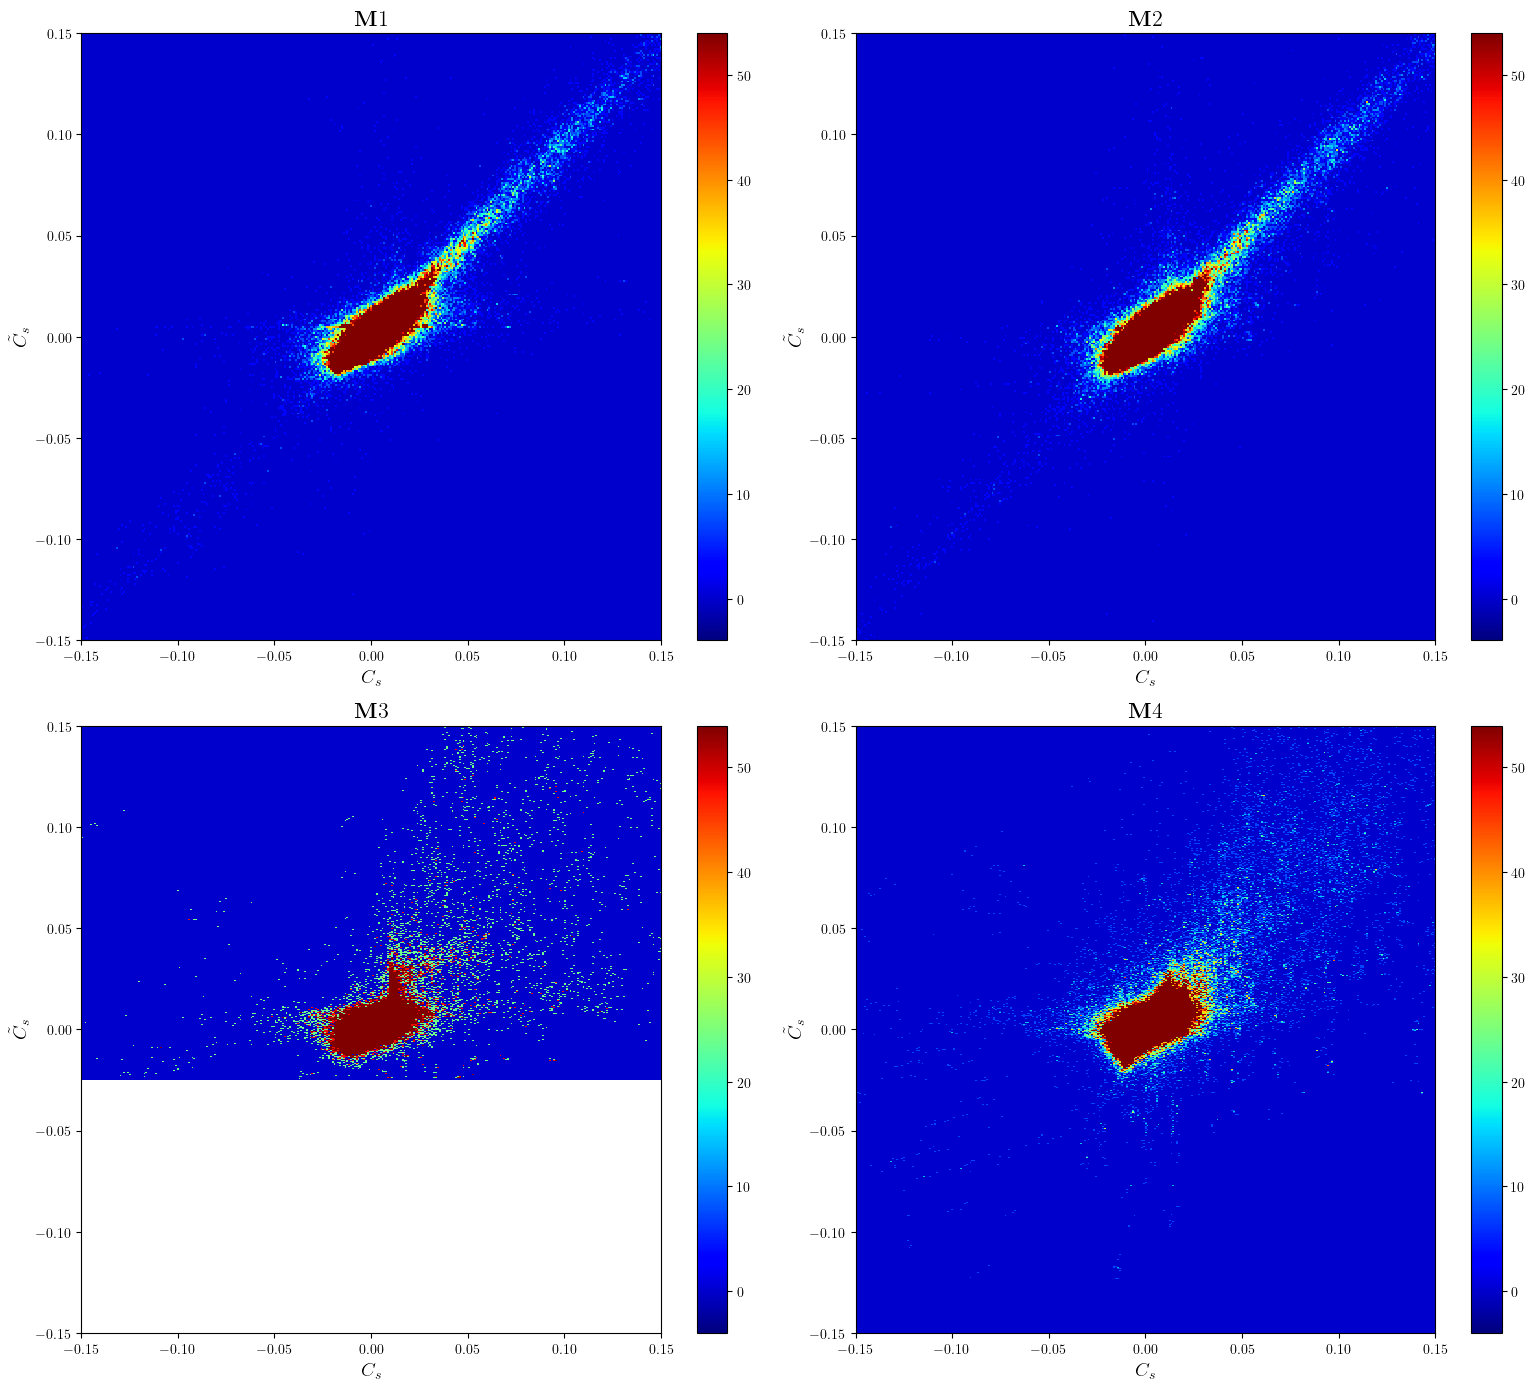

In [160]:
datasets = {
    'M1_103': M1_103,
    'M2_103': M2_103,
    'M3_103': M3_103,
    'M4_103': M4_103
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Loop through each dataset and perform calculations and plotting
for i, (dt_name, dt) in enumerate(datasets.items()):
    print(f"--- Using this Model Config: {dt_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Running on {device}!")

    PATH = f"./best_model_{dt_name}.pt"
    output_size = 1
    input_size = dt.shape[1] - output_size
    neurons_per_layer = [60, 60, 60, 60, 60]
    hidden_layers = len(neurons_per_layer)
    model = MLPModel(input_size=input_size,
                     output_size=output_size,
                     hidden_layers=hidden_layers,
                     neurons_per_layer=neurons_per_layer)

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    model.double()

    test = globals()[f"{dt_name}_test"]
    test_features = test.iloc[:, :-1].values
    test_label = test.iloc[:, -1].values
    test_features_tensor = torch.tensor(test_features).double().to(device)

    Cs_norm_pred = model(test_features_tensor)
    Cs_norm = Cs_norm_pred.detach().cpu().numpy()
    Cs_tilde = Cs_norm * dSn_R103_unseen_scales['Cs'].values + dSn_R103_unseen_means['Cs'].values
    Cs_GT = test_label * dSn_R103_unseen_scales['Cs'].values + dSn_R103_unseen_means['Cs'].values

    n, xedges, yedges = np.histogram2d(Cs_GT, Cs_tilde.squeeze(), bins=[1500, 1501])
    jpdf = n / trapz(trapz(n, xedges[:-1], axis=0), yedges[:-1])
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    ax = axes[i // 2, i % 2]
    c = ax.pcolormesh(X, Y, jpdf.T, shading='auto', cmap='jet')
    c.set_clim([-4, 54])
    ax.set_title(f'$\mathbf M{dt_name[1]}$', fontsize=16)
    ax.set_xlabel(r'$C_s$', fontsize=14)
    ax.set_ylabel(r'$\tilde{C_s}$', fontsize=14)
    ax.set_xlim([-0.15, 0.15])
    ax.set_ylim([-0.15, 0.15])
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


--- Using this Model Config: M1_103
--- Running on cuda!
--- Using this Model Config: M2_103
--- Running on cuda!
--- Using this Model Config: M3_103
--- Running on cuda!
--- Using this Model Config: M4_103
--- Running on cuda!


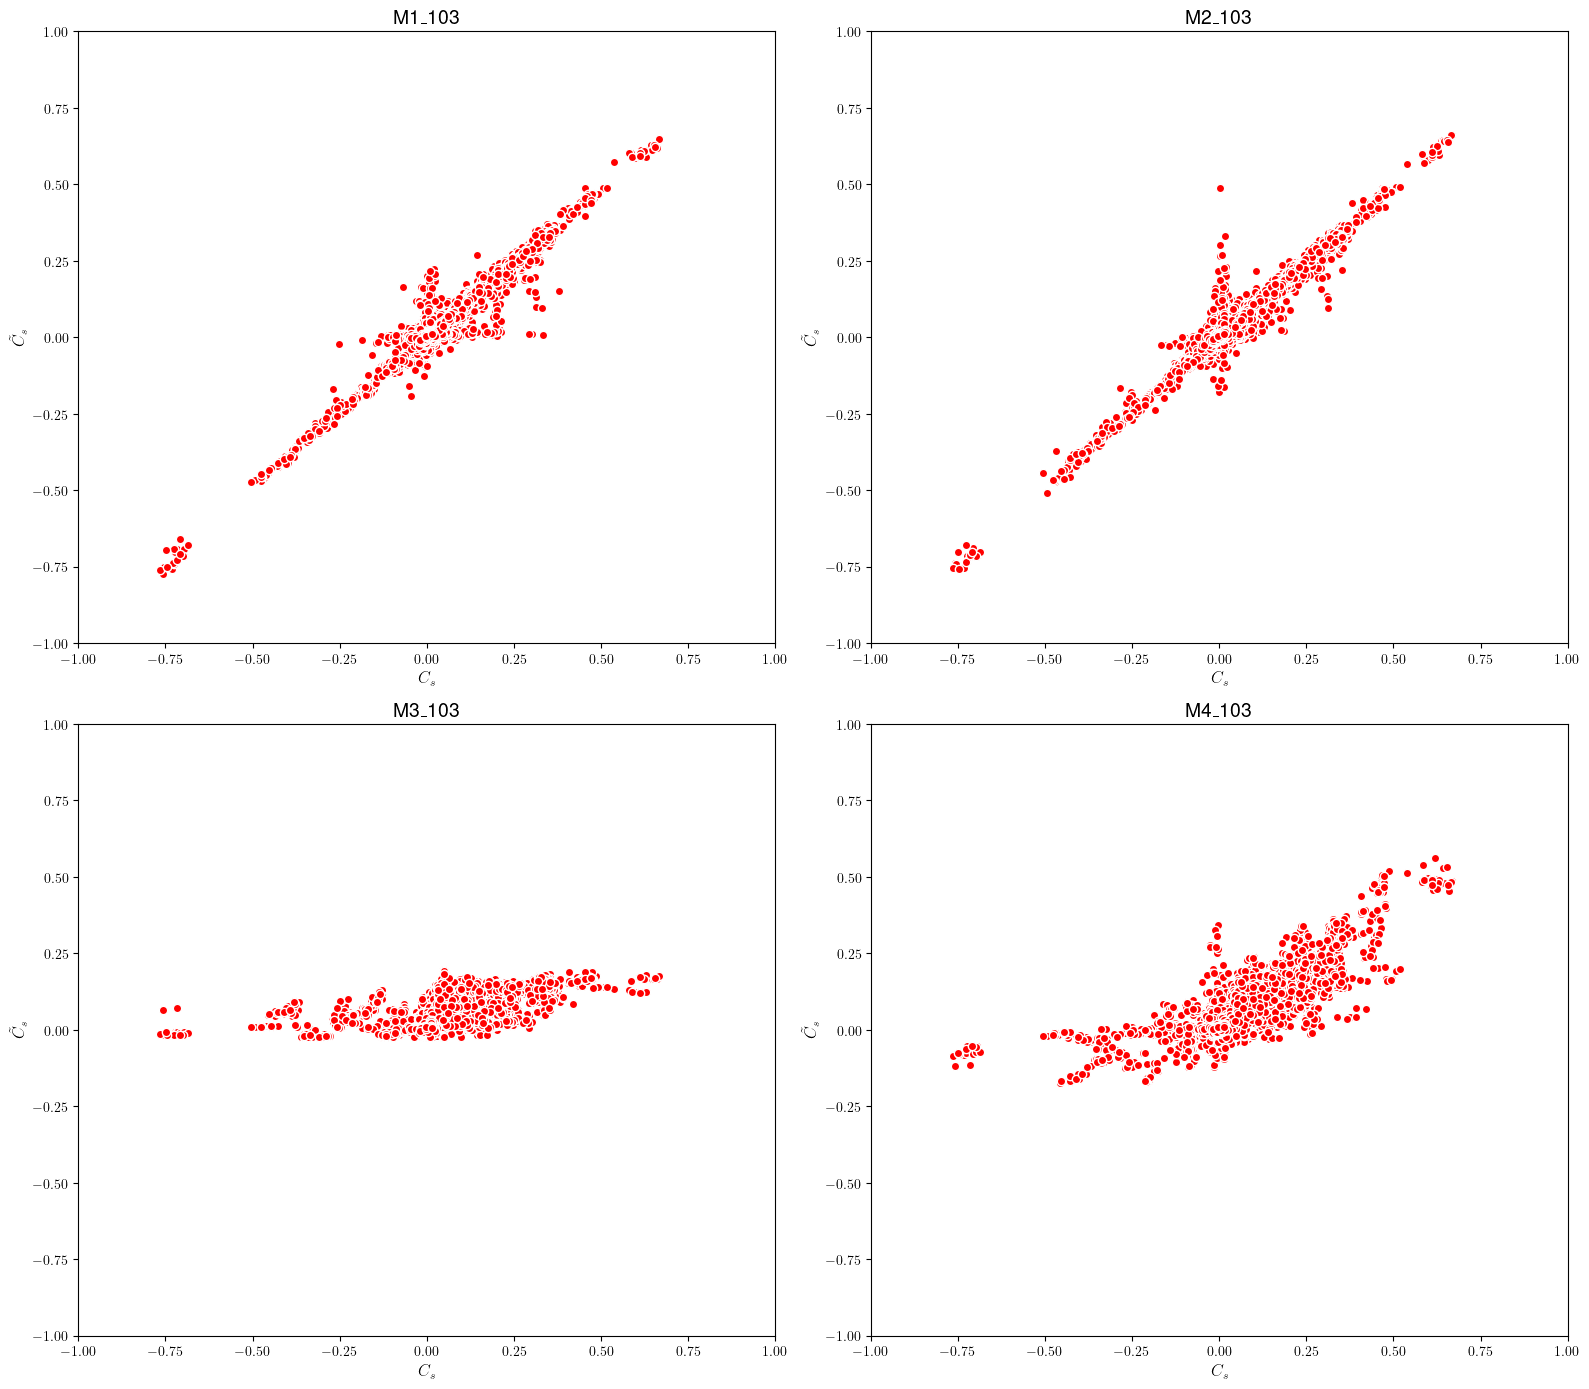

In [163]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Loop through each dataset and perform calculations and plotting
for i, (dt_name, dt) in enumerate(datasets.items()):
    print(f"--- Using this Model Config: {dt_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Running on {device}!")

    PATH = f"./best_model_{dt_name}.pt"
    output_size = 1
    input_size = dt.shape[1] - output_size
    neurons_per_layer = [60, 60, 60, 60, 60]
    hidden_layers = len(neurons_per_layer)
    model = MLPModel(input_size=input_size,
                     output_size=output_size,
                     hidden_layers=hidden_layers,
                     neurons_per_layer=neurons_per_layer)

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    model.double()

    test = globals()[f"{dt_name}_test"]
    test_features = test.iloc[:, :-1].values
    test_label = test.iloc[:, -1].values
    test_features_tensor = torch.tensor(test_features).double().to(device)

    Cs_norm_pred = model(test_features_tensor)
    Cs_norm = Cs_norm_pred.detach().cpu().numpy()
    Cs_tilde = Cs_norm * dSn_R103_unseen_scales['Cs'].values + dSn_R103_unseen_means['Cs'].values
    Cs_GT = test_label * dSn_R103_unseen_scales['Cs'].values + dSn_R103_unseen_means['Cs'].values

    ax = axes[i // 2, i % 2]
    ax.scatter(Cs_GT, Cs_tilde.squeeze(), edgecolor='white', color='red')
    ax.set_title(f'{dt_name}', fontsize=14)
    ax.set_xlabel(r'$C_s$', fontsize=12)
    ax.set_ylabel(r'$\tilde{C_s}$', fontsize=12)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

plt.tight_layout()
plt.show()


--------------------

## $\mathcal Re = 5 \times 10^3$

--- Using this Model Config: M1_503
--- Running on cuda!
--- Using this Model Config: M2_503
--- Running on cuda!
--- Using this Model Config: M3_503
--- Running on cuda!
--- Using this Model Config: M4_503
--- Running on cuda!


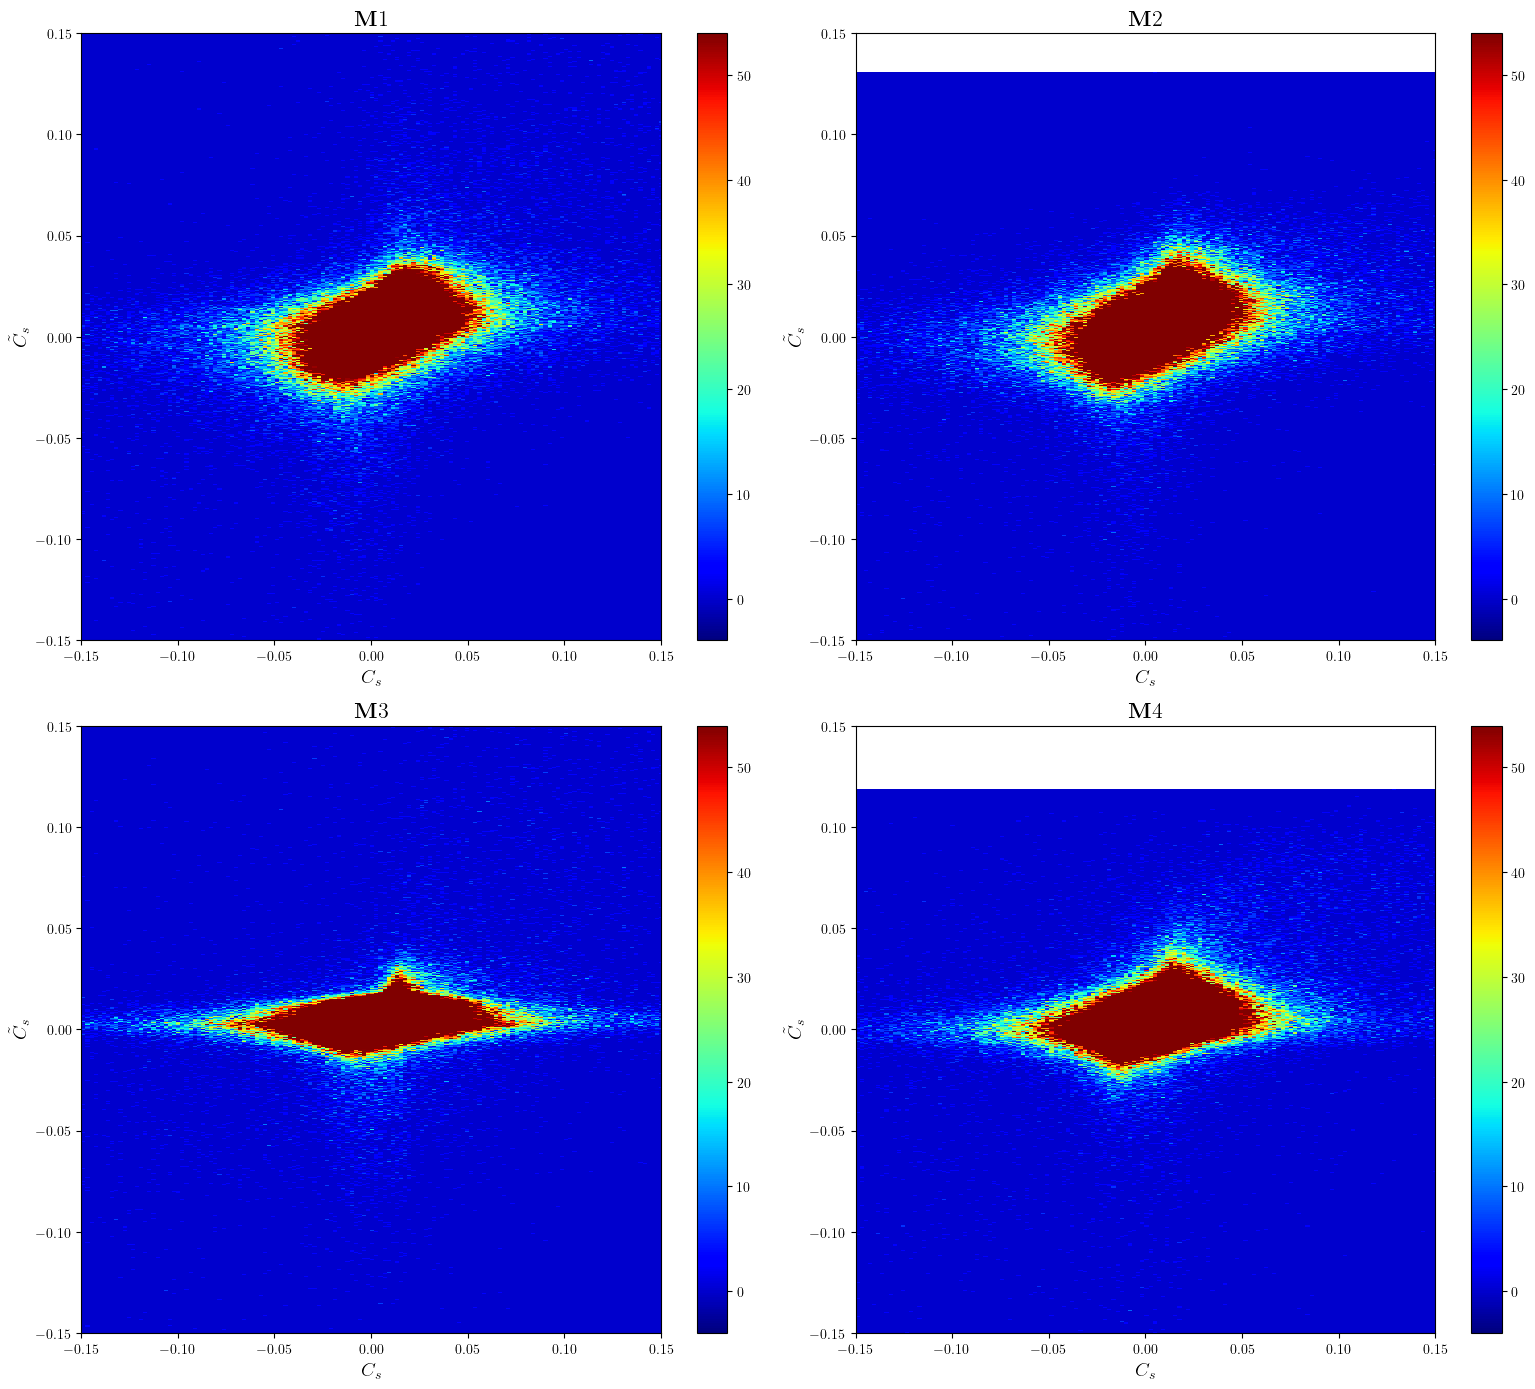

In [167]:
datasets = {
    'M1_503': M1_503,
    'M2_503': M2_503,
    'M3_503': M3_503,
    'M4_503': M4_503
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Loop through each dataset and perform calculations and plotting
for i, (dt_name, dt) in enumerate(datasets.items()):
    print(f"--- Using this Model Config: {dt_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Running on {device}!")

    PATH = f"./best_model_{dt_name}.pt"
    output_size = 1
    input_size = dt.shape[1] - output_size
    neurons_per_layer = [60, 60, 60, 60, 60]
    hidden_layers = len(neurons_per_layer)
    model = MLPModel(input_size=input_size,
                     output_size=output_size,
                     hidden_layers=hidden_layers,
                     neurons_per_layer=neurons_per_layer)

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    model.double()

    test = globals()[f"{dt_name}_test"]
    test_features = test.iloc[:, :-1].values
    test_label = test.iloc[:, -1].values
    test_features_tensor = torch.tensor(test_features).double().to(device)

    Cs_norm_pred = model(test_features_tensor)
    Cs_norm = Cs_norm_pred.detach().cpu().numpy()
    Cs_tilde = Cs_norm * dSn_R503_unseen_scales['Cs'].values + dSn_R503_unseen_means['Cs'].values
    Cs_GT = test_label * dSn_R503_unseen_scales['Cs'].values + dSn_R503_unseen_means['Cs'].values

    n, xedges, yedges = np.histogram2d(Cs_GT, Cs_tilde.squeeze(), bins=[1500, 1501])
    jpdf = n / trapz(trapz(n, xedges[:-1], axis=0), yedges[:-1])
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    ax = axes[i // 2, i % 2]
    c = ax.pcolormesh(X, Y, jpdf.T, shading='auto', cmap='jet')
    c.set_clim([-4, 54])
    ax.set_title(f'$\mathbf M{dt_name[1]}$', fontsize=16)
    ax.set_xlabel(r'$C_s$', fontsize=14)
    ax.set_ylabel(r'$\tilde{C_s}$', fontsize=14)
    ax.set_xlim([-0.15, 0.15])
    ax.set_ylim([-0.15, 0.15])
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


--------------------

## $\mathcal Re = 10^4$

--- Using this Model Config: M1_104
--- Running on cuda!
--- Using this Model Config: M2_104
--- Running on cuda!
--- Using this Model Config: M3_104
--- Running on cuda!
--- Using this Model Config: M4_104
--- Running on cuda!


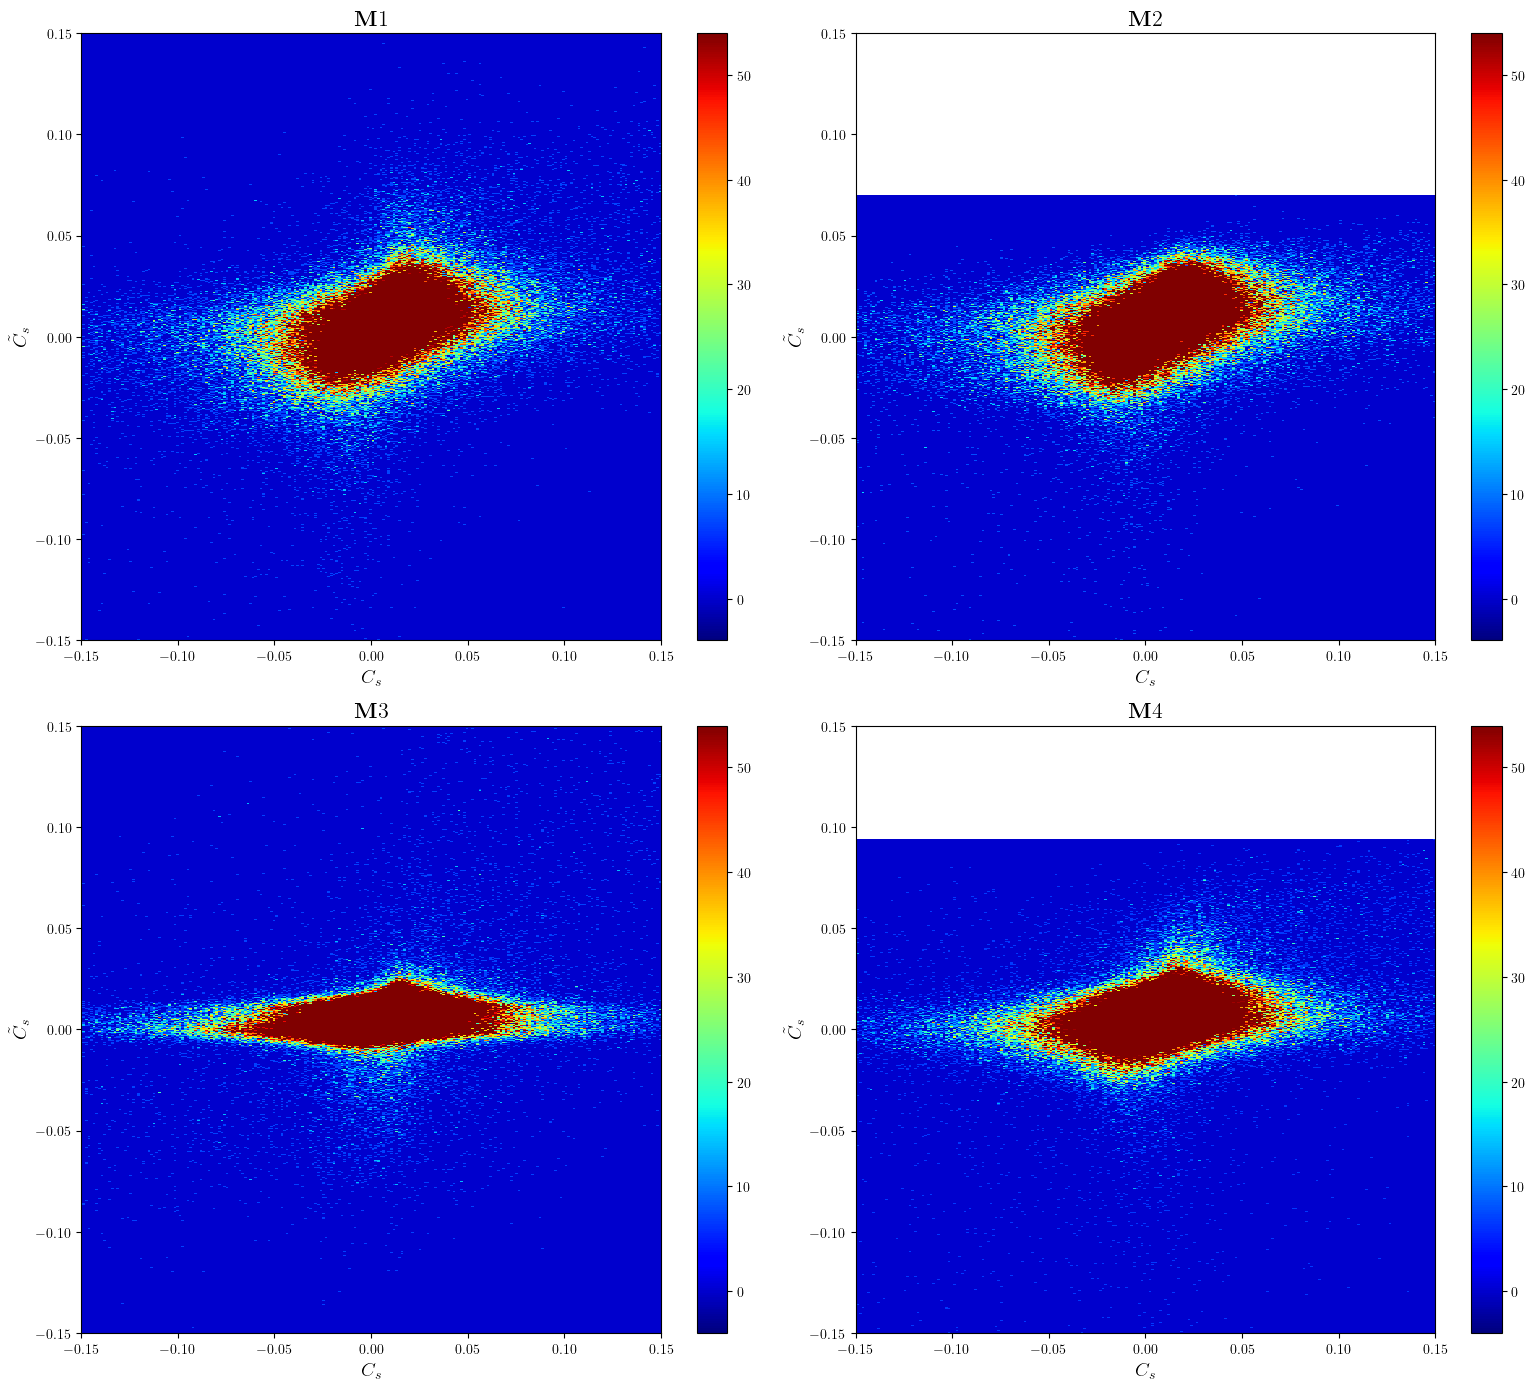

In [168]:
datasets = {
    'M1_104': M1_104,
    'M2_104': M2_104,
    'M3_104': M3_104,
    'M4_104': M4_104
}

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Loop through each dataset and perform calculations and plotting
for i, (dt_name, dt) in enumerate(datasets.items()):
    print(f"--- Using this Model Config: {dt_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"--- Running on {device}!")

    PATH = f"./best_model_{dt_name}.pt"
    output_size = 1
    input_size = dt.shape[1] - output_size
    neurons_per_layer = [60, 60, 60, 60, 60]
    hidden_layers = len(neurons_per_layer)
    model = MLPModel(input_size=input_size,
                     output_size=output_size,
                     hidden_layers=hidden_layers,
                     neurons_per_layer=neurons_per_layer)

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    model.double()

    test = globals()[f"{dt_name}_test"]
    test_features = test.iloc[:, :-1].values
    test_label = test.iloc[:, -1].values
    test_features_tensor = torch.tensor(test_features).double().to(device)

    Cs_norm_pred = model(test_features_tensor)
    Cs_norm = Cs_norm_pred.detach().cpu().numpy()
    Cs_tilde = Cs_norm * dSn_R104_unseen_scales['Cs'].values + dSn_R104_unseen_means['Cs'].values
    Cs_GT = test_label * dSn_R104_unseen_scales['Cs'].values + dSn_R104_unseen_means['Cs'].values

    n, xedges, yedges = np.histogram2d(Cs_GT, Cs_tilde.squeeze(), bins=[1500, 1501])
    jpdf = n / trapz(trapz(n, xedges[:-1], axis=0), yedges[:-1])
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    ax = axes[i // 2, i % 2]
    c = ax.pcolormesh(X, Y, jpdf.T, shading='auto', cmap='jet')
    c.set_clim([-4, 54])
    ax.set_title(f'$\mathbf M{dt_name[1]}$', fontsize=16)
    ax.set_xlabel(r'$C_s$', fontsize=14)
    ax.set_ylabel(r'$\tilde{C_s}$', fontsize=14)
    ax.set_xlim([-0.15, 0.15])
    ax.set_ylim([-0.15, 0.15])
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()
